First we generate the balance and card transactions dataset. We assume that there is a weak relationship between card transactions and balance. The assumption is that users with more balance will use their card more often. This relationship is weak because users with more balance will generally make bigger payments, but not necessarily more frequent payments.

In [34]:
import numpy as np
import pandas as pd

num_records = 100000
proportion_small = 0.7

# Define an engagement index, skewed toward extreme values
user_engagement_index_low = np.random.triangular(left=0, mode=0.1, right=0.7, size=int(num_records * proportion_small))
user_engagement_index_high = np.random.triangular(left=0.6, mode=0.8, right=1, size=int(num_records * (1 - proportion_small)))
user_engagement_index = np.concatenate([user_engagement_index_low, user_engagement_index_high])

# Add random noise to the engagement index
proportion_noise = 0.5
noise = np.random.normal(loc=0.5, scale=0.3, size=num_records)
user_engagement_index_noisy = noise * (proportion_noise) + user_engagement_index * (1-proportion_noise)

# Derive the balance and the card transactions using the engagement indexes
average_balance_last_90d = (user_engagement_index * 10000).round(2)
nb_card_transactions_last_90d = (user_engagement_index_noisy * 250)

# Create DataFrame
df = pd.DataFrame({
    "average_balance_last_90d": average_balance_last_90d,
    "nb_card_transactions_last_90d": nb_card_transactions_last_90d
})

# Filter out irrelevant records generated by the noise
df = df[(df['nb_card_transactions_last_90d'] >= 0)]
df = df[(df['average_balance_last_90d'] >= 0)]

df.head()

,average_balance_last_90d,nb_card_transactions_last_90d
0,4007.61,172.203070
1,2415.91,97.427753
2,1958.20,163.387667
3,3534.45,114.271414
4,2328.98,120.734943


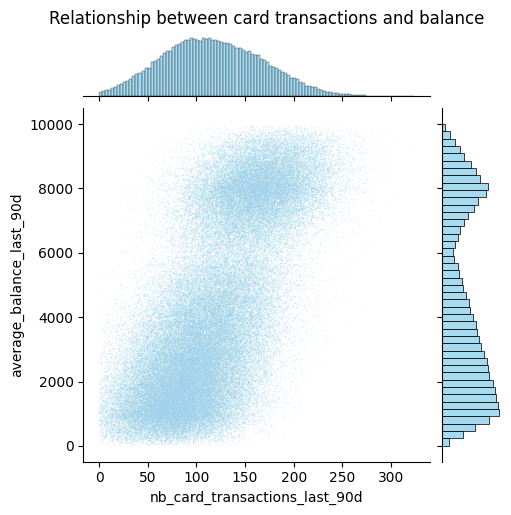

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.jointplot(x='nb_card_transactions_last_90d', y='average_balance_last_90d', data=df, kind='scatter', color='skyblue', alpha=0.2, marker='o', height=5, s=1)
plt.suptitle('Relationship between card transactions and balance', y=1.02)
plt.show()

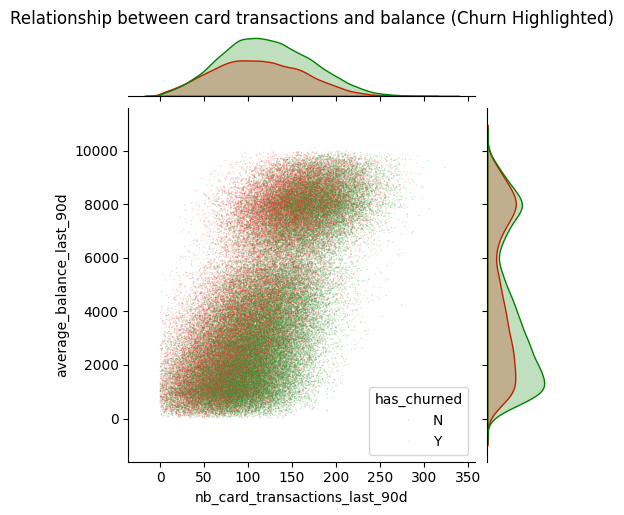

In [ ]:
# Define the churn probability
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Calculate churn probability
df['churn_probability'] = sigmoid(
    1 * np.random.normal(loc=0, scale=1, size=len(df))  # Random factor
    + 1.5 * (df['average_balance_last_90d'] / 10000)    # Balance increases the likelihood to churn
    - 2 * (df['nb_card_transactions_last_90d'] / 250)   # Card usage reduces the likelihood to churn
)

# Assign 'has_churned' based on churn probability
df['has_churned'] = np.where(df['churn_probability'] > 0.5, 'Y', 'N')

# Create scatter plot with hue for churn
sns.jointplot(
    x='nb_card_transactions_last_90d', 
    y='average_balance_last_90d', 
    data=df, 
    kind='scatter', 
    hue='has_churned',
    palette={'Y': 'red', 'N': 'green'},
    alpha=0.2, 
    marker='o', 
    height=5, 
    s=1
)

plt.suptitle('Relationship between card transactions and balance (Churn Highlighted)', y=1.02)
plt.show()

In [37]:
import statsmodels.api as sm

# Calculate the mean and standard deviation for each feature
mean_transactions = df['nb_card_transactions_last_90d'].mean()
std_transactions = df['nb_card_transactions_last_90d'].std()
mean_balance = df['average_balance_last_90d'].mean()
std_balance = df['average_balance_last_90d'].std()

# Standardize the features to obtain more comparable coefficients
df['nb_card_transactions_last_90d_standardized'] = (df['nb_card_transactions_last_90d'] - mean_transactions) / std_transactions
df['average_balance_last_90d_standardized'] = (df['average_balance_last_90d'] - mean_balance) / std_balance

# Prepare the standardized features for the model
X = df[['nb_card_transactions_last_90d_standardized', 'average_balance_last_90d_standardized']]

# Add constant (intercept) term to the model
X = sm.add_constant(X)

# Define the dependent variable (target)
df['has_churned'] = df['has_churned'].map({'Y': 1, 'N': 0})
y = df['has_churned']

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.637313
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            has_churned   No. Observations:                99237
Model:                          Logit   Df Residuals:                    99234
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 Jan 2025   Pseudo R-squ.:                 0.04731
Time:                        01:18:35   Log-Likelihood:                -63245.
converged:                       True   LL-Null:                       -66386.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       